In [2]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("/scratch/ewalt/pdm/rs-uncertainty")
from src.utils import SpatialCorrelationAnalyzer
import rasterio
import json
import argparse
import yaml
import numpy as np
from tqdm import tqdm
from pathlib import Path
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

In [3]:
with Path("./config/evaluate_testset/baseline.yaml").open("r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)
for k, v in cfg.items():
    if k.endswith("_dir"): cfg[k] = Path(v)

In [4]:
def pjoin(*subs): return Path(os.path.abspath(os.path.join(*subs)))
def get_project_arrays(cfg, N=4, normalize_variance=False):
    arrays = []
    for variance_file in tqdm(list(cfg["prediction_dir"].glob("*_variance.tif"))[:N]):
        projects = cfg["projects_east"]+cfg["projects_west"]+cfg["projects_north"]
        project = variance_file.stem.split("_")[0]
        if project not in projects: continue
        with rasterio.open(variance_file) as fh:
            variance = fh.read(fh.indexes)
        with rasterio.open(pjoin(cfg['prediction_dir'], f"{project}_mean.tif")) as fh:
            mean = fh.read(fh.indexes)
        with rasterio.open(pjoin(cfg['gt_dir'], f"{project}.tif")) as fh:
            gt = fh.read(fh.indexes)
            gt[2] /= 100 # Cover/Dens normalization!!
            gt[4] /= 100
        arrays.append((gt, mean, variance))
    return arrays

In [6]:
gt, mean, variance = get_project_arrays(cfg)[3]

100%|████████████████████████████████████████| 4/4 [00:07<00:00,  1.58s/it]


### Analyzer

In [14]:
sca = SpatialCorrelationAnalyzer()
sca.fit(gt, mean)

[[[-4.22169628 -4.22105473 -4.21795358 ... -4.22105473 -4.21795358
   -4.21663534]
  [-4.21978732 -4.22169628 -4.22105473 ... -4.22169628 -4.22105473
   -4.21795358]
  [-4.21663534 -4.21978732 -4.22169628 ... -4.20852543 -4.2104315
   -4.20979237]
  ...
  [ 1.16339511  1.16287073  1.16235362 ...  1.16287073  1.16235362
    1.1619974 ]
  [ 1.16276808  1.16339511  1.16287073 ...  1.174657    1.17413552
    1.17361598]
  [ 1.17325253  1.17402206  1.174657   ...  1.17402206  1.174657
    1.17413552]]

 [[ 1.17361598  1.17325253  1.17402206 ...  1.17325253  1.17402206
    1.174657  ]
  [ 1.1854003   1.18487834  1.18450766 ...  1.18487834  1.18450766
    1.18527604]
  [ 1.18591888  1.1854003   1.18487834 ...  1.1854003   1.18487834
    1.18450766]
  ...
  [ 6.56996732  6.56828669  6.56445864 ...  6.56828669  6.56445864
    6.56467946]
  [ 6.56910131  6.56996732  6.56828669 ...  6.56996732  6.56828669
    6.56445864]
  [ 6.56467946  6.56910131  6.56996732 ...  6.5803632   6.5812321
    6.5795

In [32]:
(sca.pred.shape, sca.gt.shape, sca.res.shape), \
(sca.pred_decorr.shape, sca.gt_decorr.shape, sca.res_decorr.shape)

(((5, 1199, 2944), (5, 1199, 2944), (5, 1199, 2944)),
 ((5, 1199, 2944), (5, 1199, 2944), (5, 1199, 2944)))

In [33]:
1199*2944

3529856

### Residual plots

(60951,) (60951,)


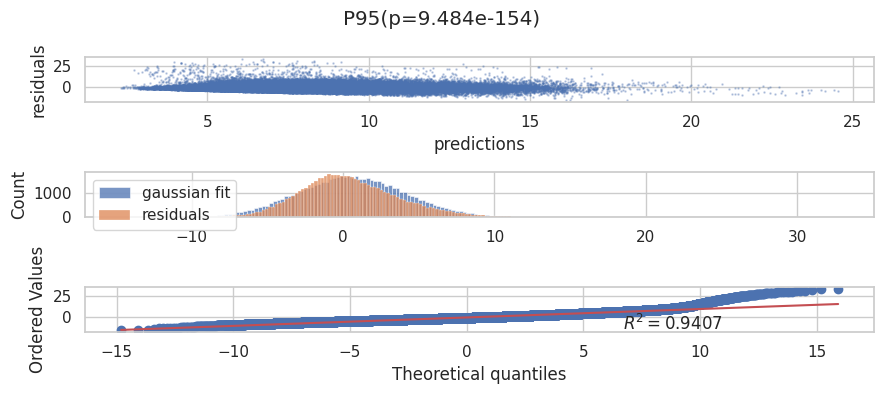

(60951,) (60951,)


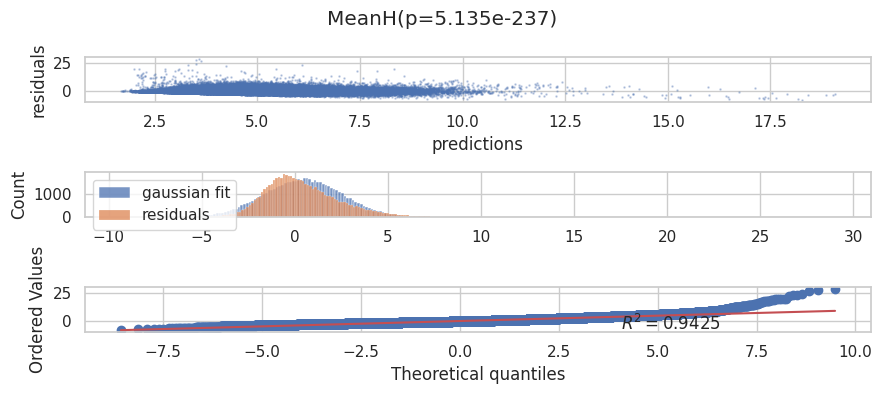

(60951,) (60951,)


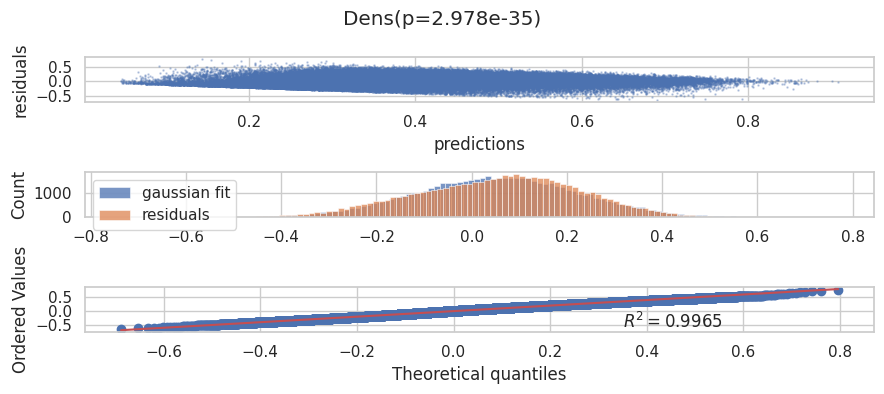

(60951,) (60951,)


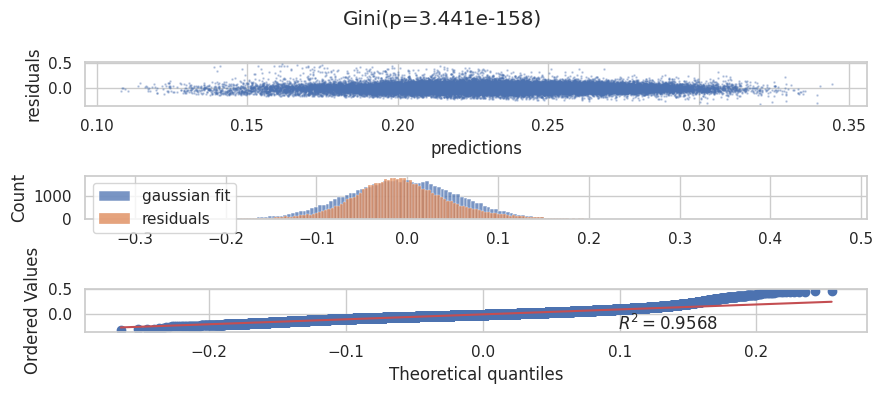

(60951,) (60951,)


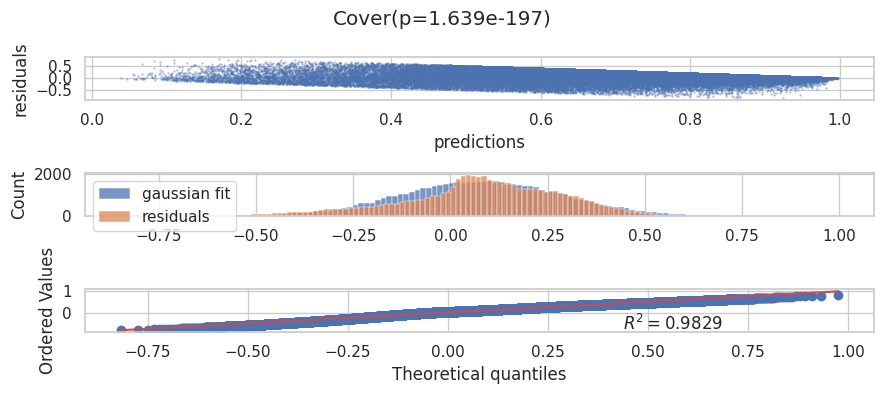

In [44]:
sca.plot_residuals(kind="original", variable_names=cfg["variable_names"])

(60951,) (60951,)


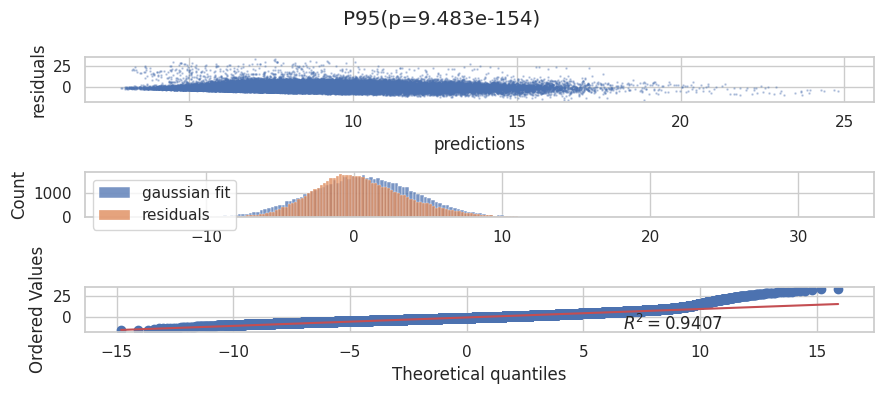

(60951,) (60951,)


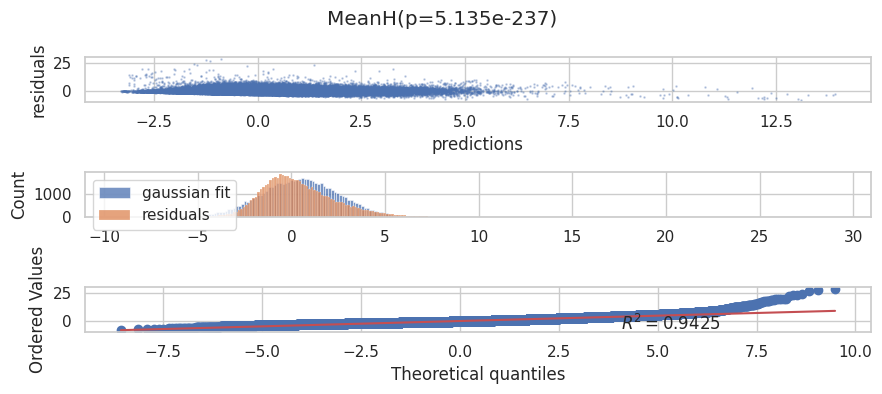

(60951,) (60951,)


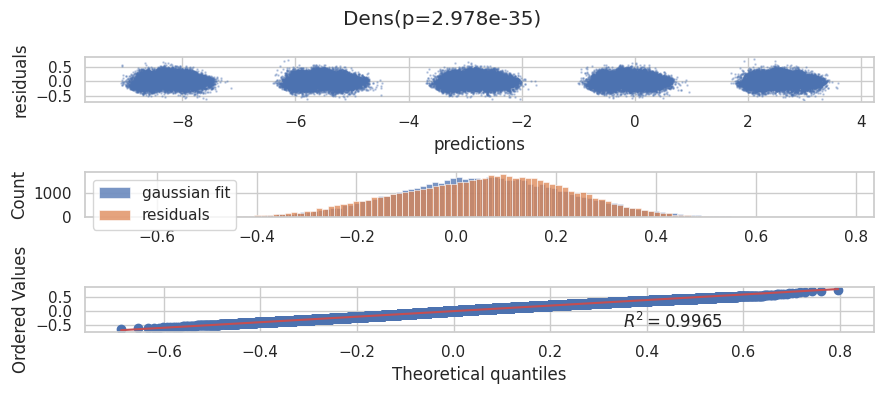

(60951,) (60951,)


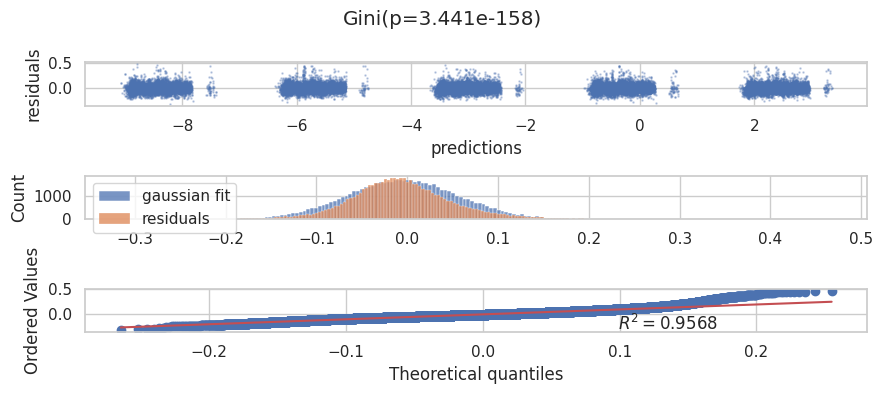

(60951,) (60951,)


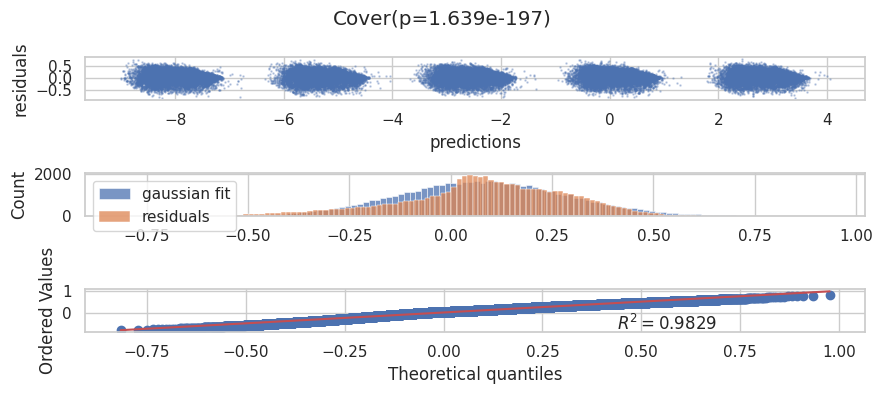

In [43]:
sca.plot_residuals(kind="decorrelated", variable_names=cfg["variable_names"])

/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


(2944, 5)


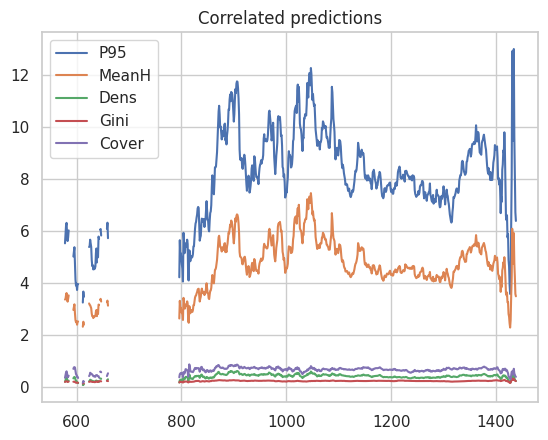

/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


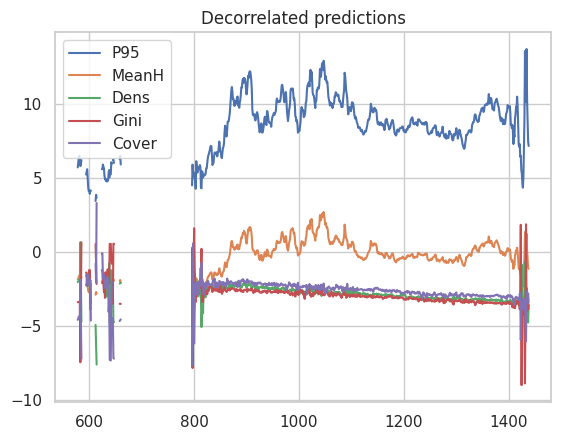

In [25]:
x = np.nanmean(sca.pred, axis=1).transpose() # (n_x, 5)
print(x.shape)
plt.plot(np.arange(x.shape[0]), x, label=cfg["variable_names"])
plt.legend()
plt.title("Correlated predictions")
plt.show()
x = np.nanmean(sca.pred_decorr, axis=1).transpose() # (n_x, 5)
plt.plot(np.arange(x.shape[0]), x, label=cfg["variable_names"])
plt.legend()
plt.title("Decorrelated predictions")
plt.show()

In [164]:
diff = sca.res_decorr-sca.res
(diff[:,~np.isnan(diff).all(0)]==0).all(), np.allclose(sca.res_decorr[:,~np.isnan(sca.res_decorr).all(0)],sca.res[:,~np.isnan(sca.res).all(0)])

(False, True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(5, 1199, 2944)


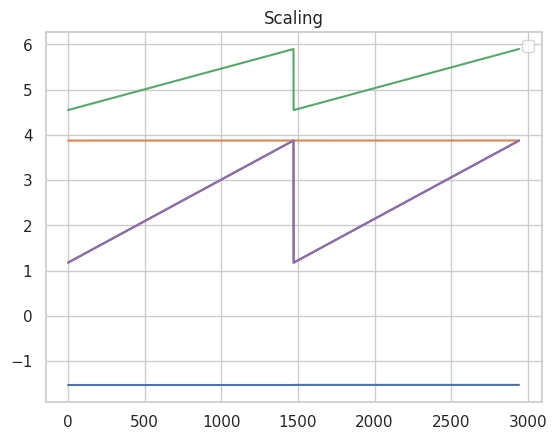

/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


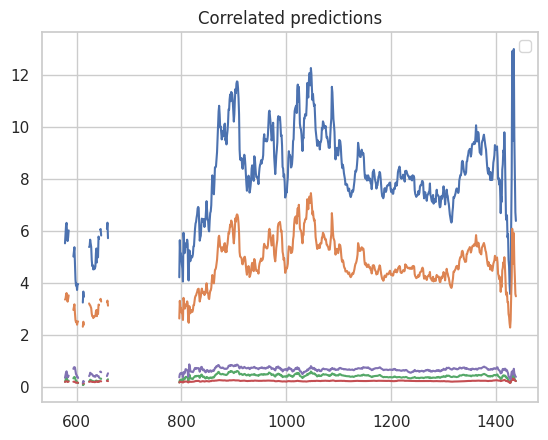

/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


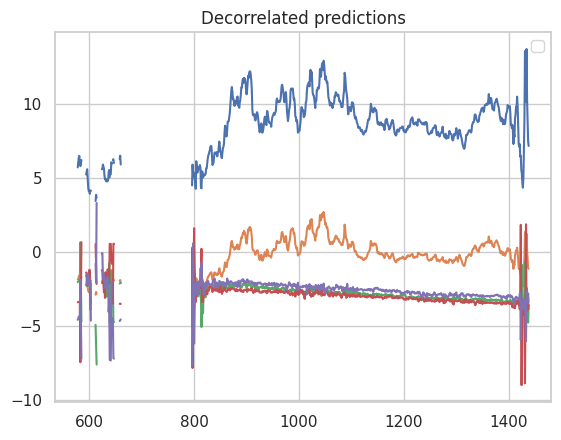

In [12]:
from sklearn.linear_model import LinearRegression
pred = mean
mask = ~np.isnan(pred).all(0)
locations = np.indices(pred.shape[1:], dtype=float)
locations[0,:,:] /= float(locations.shape[1]-1)
locations[1,:,:] /= float(locations.shape[2]-1)
x = locations[:,mask].reshape(-1,2)
y = pred[:,mask].reshape(-1,5)
model = LinearRegression().fit(x,y)
scaling = model.predict(locations.reshape(-1,2)).reshape(pred.shape)
print(scaling.shape)
x = np.nanmean(scaling, axis=1).transpose() # (n_x, 5)
plt.plot(np.arange(x.shape[0]), x)#, label=cfg["variable_names"])
plt.legend()
plt.title("Scaling")
plt.show()
x = np.nanmean(pred, axis=1).transpose() # (n_x, 5)
plt.plot(np.arange(x.shape[0]), x)#, label=cfg["variable_names"])
plt.legend()
plt.title("Correlated predictions")
plt.show()
x = np.nanmean(pred-scaling, axis=1).transpose() # (n_x, 5)
plt.plot(np.arange(x.shape[0]), x)#, label=cfg["variable_names"])
plt.legend()
plt.title("Decorrelated predictions")
plt.show()

### Residuals normality test

In [59]:
nnan_mean = mean[:,~np.isnan(mean).all(0)]
nnan_gt = gt[:,~np.isnan(mean).all(0)]
nnan_residuals = nnan_gt - nnan_mean
nnan_mean.shape, nnan_gt.shape, nnan_residuals.shape

((5, 60951), (5, 60951), (5, 60951))

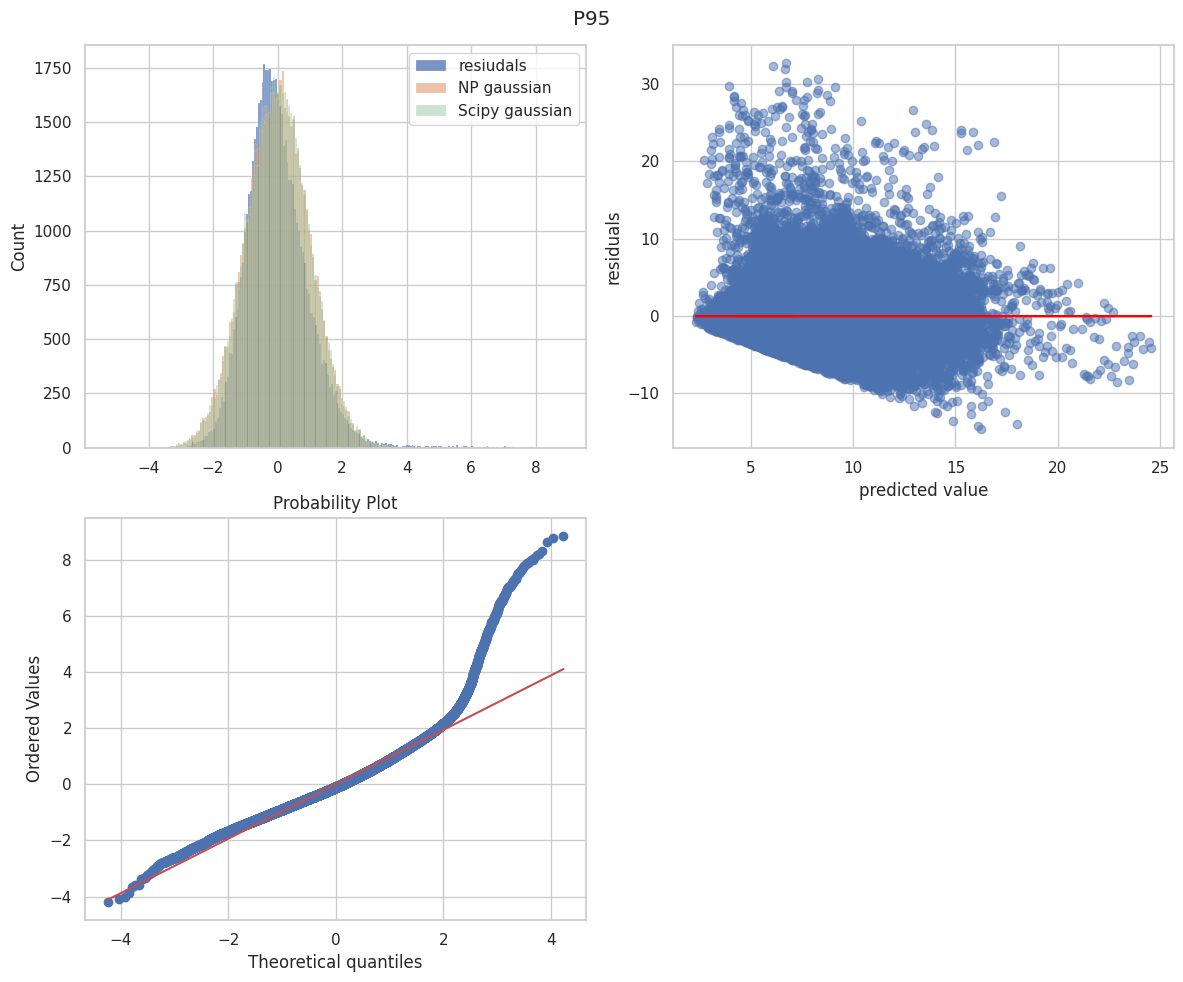

scipy_norm:  0.2183638144978327
np_norm:  0.9456264637382379
residuals:  9.48433387614766e-154


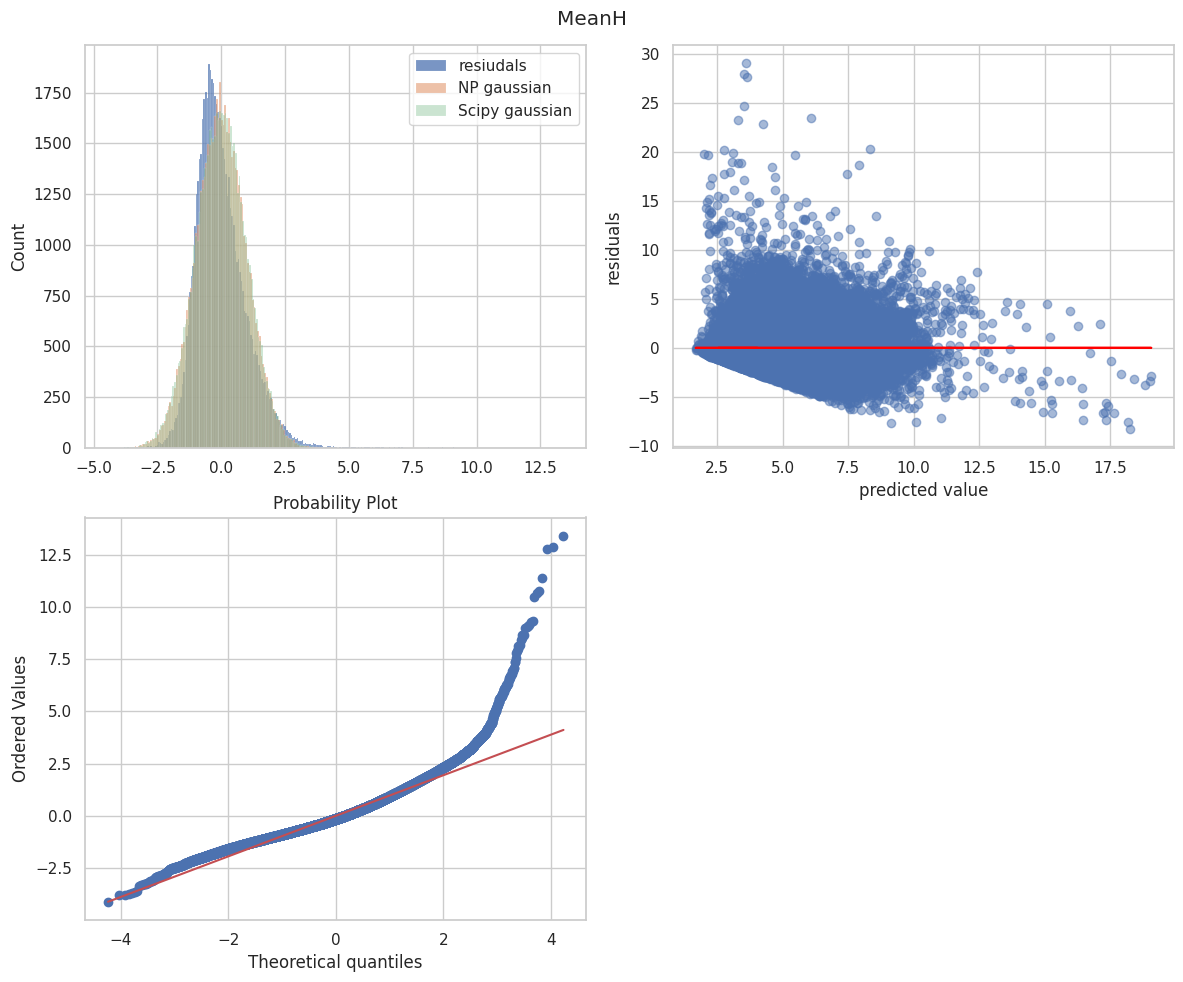

scipy_norm:  0.8292290458296602
np_norm:  0.08252257564808485
residuals:  5.134832604947683e-237


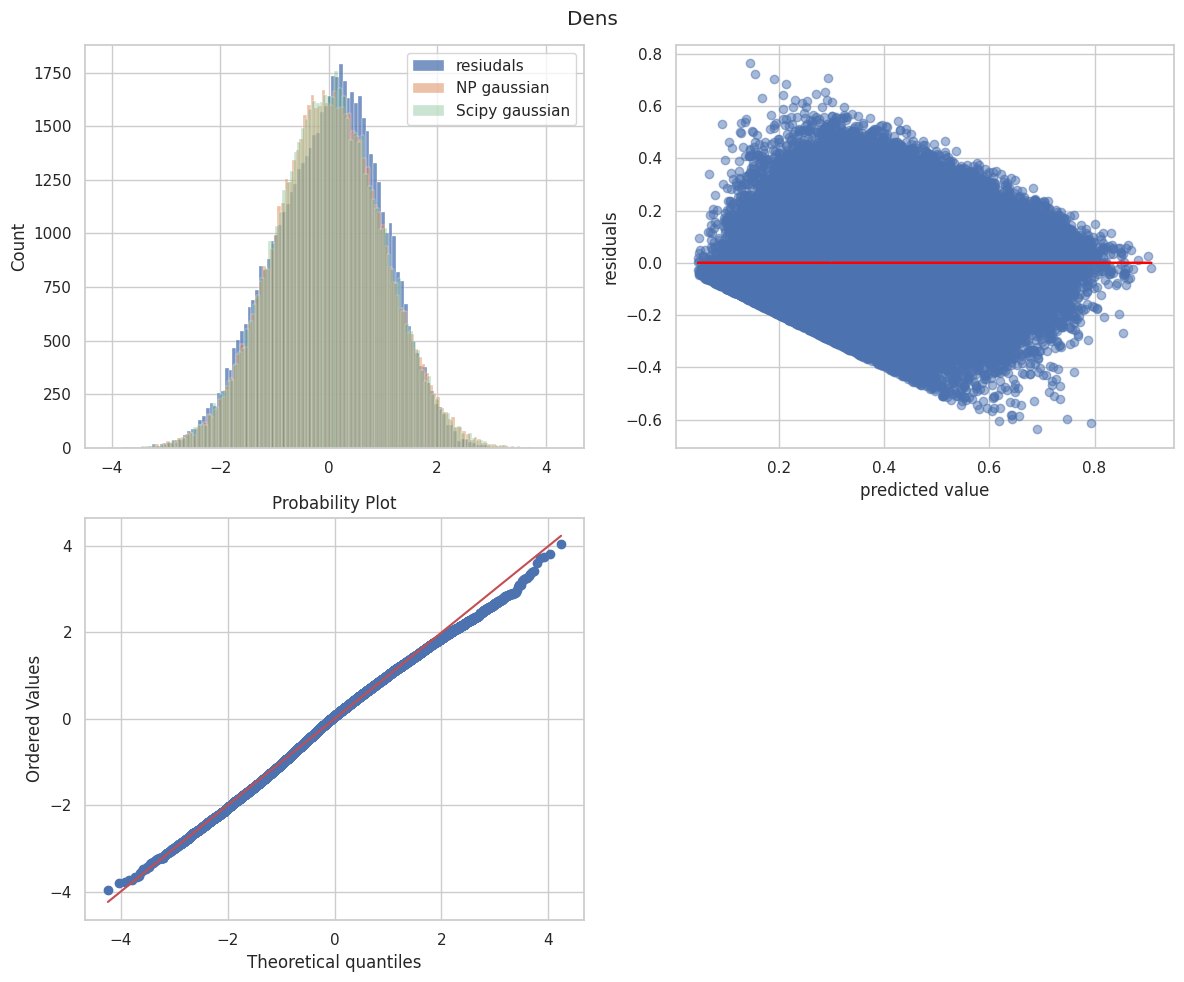

scipy_norm:  0.7391625080817399
np_norm:  0.5307528717447065
residuals:  2.977559666120179e-35


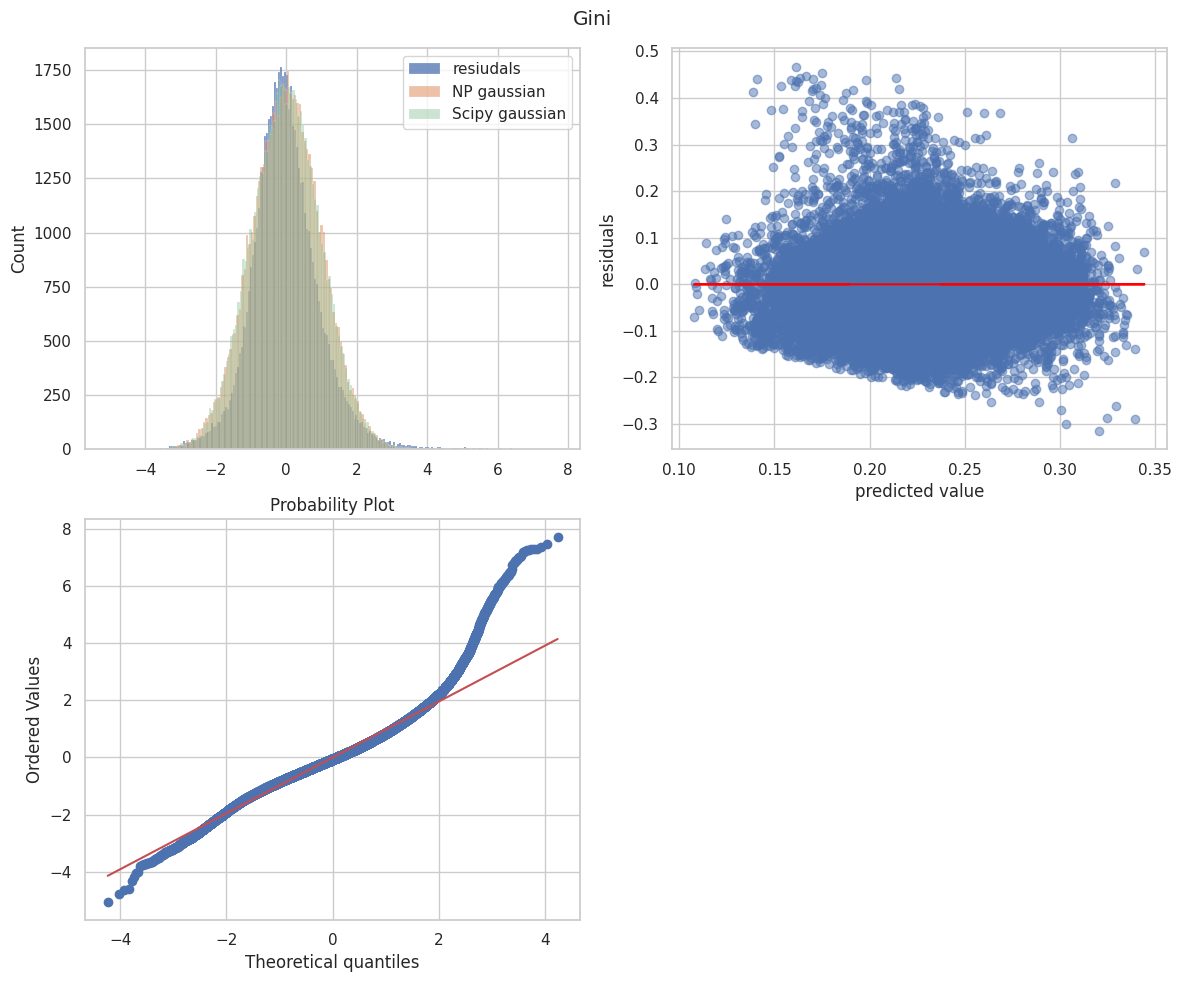

scipy_norm:  0.23571160694595383
np_norm:  0.25242814992953355
residuals:  3.4409904455866164e-158


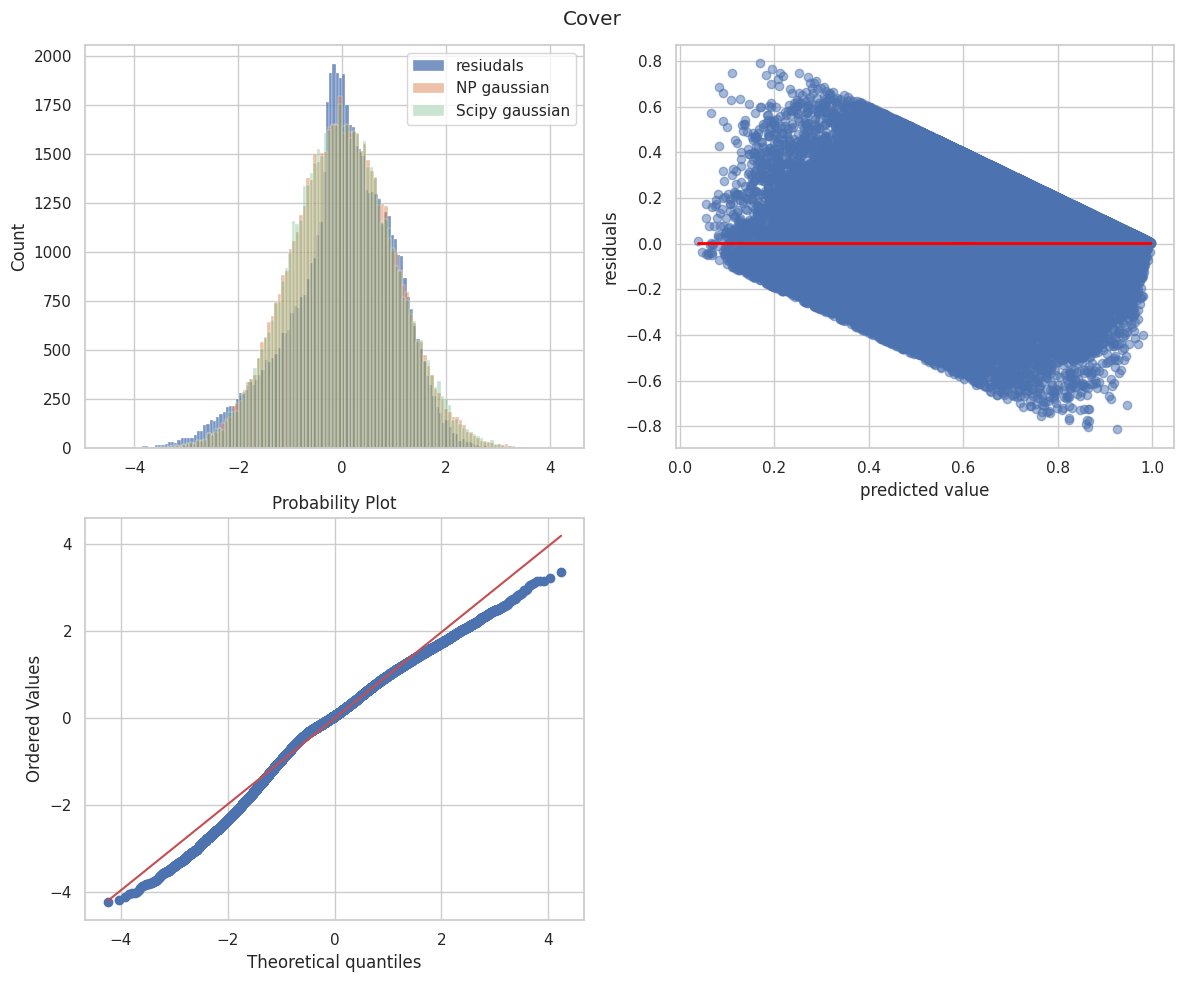

scipy_norm:  0.8446635298755193
np_norm:  0.5084982456538076
residuals:  1.639147439840137e-197


In [126]:
for i in range(5):
    tmp = nnan_residuals[i].copy()
    tmp = (tmp-tmp.mean())/tmp.std()
    scipy_norm = stats.norm.rvs(size=tmp.shape[0])
    np_norm = np.random.randn(*tmp.shape)
    fig = plt.figure(figsize=(12,10))
    fig.add_subplot(221) # top left
    sns.histplot(tmp, label="resiudals")
    sns.histplot(np_norm, label="NP gaussian", alpha=0.5)
    sns.histplot(scipy_norm, label="Scipy gaussian", alpha=0.3)
    plt.legend()
    fig.add_subplot(223) # bottom left
    stats.probplot(tmp, plot=plt)
    fig.add_subplot(222) # top right
    plt.scatter(nnan_mean[i], nnan_residuals[i], alpha=0.5)
    plt.plot(nnan_mean[i], np.zeros_like(nnan_mean[i]), color="red")
    plt.xlabel("predicted value")
    plt.ylabel("residuals")
    fig.suptitle(cfg["variable_names"][i])
    plt.tight_layout()
    plt.show()
    # statistical tests
    pval = stats.kstest(scipy_norm, cdf="norm").pvalue
    # pval = stats.normaltest(scipy_norm).pvalue
    print("scipy_norm: ", pval)
    pval = stats.kstest(np_norm, cdf="norm").pvalue
    # pval = stats.normaltest(np_norm).pvalue
    print("np_norm: ", pval)
    pval = stats.kstest(tmp, cdf="norm").pvalue
    # pval = stats.normaltest(tmp).pvalue
    print("residuals: ", pval)

In [131]:
stats.chisquare(tmp, scipy_norm) # p < alpha => reject H0 i.e. different frequencies
# p > alpha => may not have different frequencies

Power_divergenceResult(statistic=87256.87170585431, pvalue=0.0)

### Scatter predicted mean vs variance

In [25]:
def get_residuals_variances(cfg, N, normalize_variance=False):
    arrays = get_project_arrays(cfg, N, normalize_variance)
    gts, means, variances = tuple(zip(*arrays))
    flatresiduals = []
    flatvars = []
    for gt, mean, var in zip(gts, means, variances):
        mask = ~np.isnan(mean).all(0)
        flatresiduals.append(gt[:,mask]-mean[:,mask])
        flatvars.append(var[:,mask])
    flatresiduals = np.concatenate(flatresiduals, axis=1)
    flatvars = np.concatenate(flatvars, axis=1)
    return flatresiduals, flatvars

In [32]:
def scatter_residuals_vs_var(residuals, variances, variable_names):
    for i in range(5):
        fig = plt.figure(figsize=(10,10))
        df = pd.DataFrame({"residuals": residuals[i].tolist(), 
                           "predicted variance": variances[i].tolist()})
        sns.jointplot(data=df, x="residuals", y="predicted variance", alpha=.4)
        fig.suptitle(variable_names[i])
        plt.show()

100%|██████████████████████████████████████| 10/10 [00:28<00:00,  3.01s/it]


<Figure size 1000x1000 with 0 Axes>

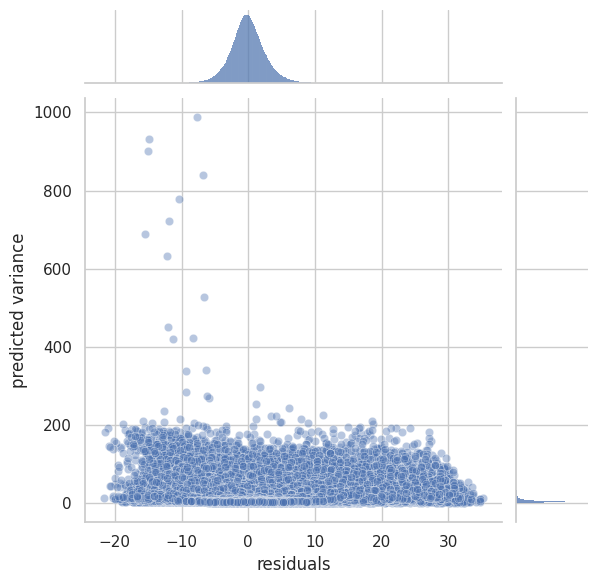

<Figure size 1000x1000 with 0 Axes>

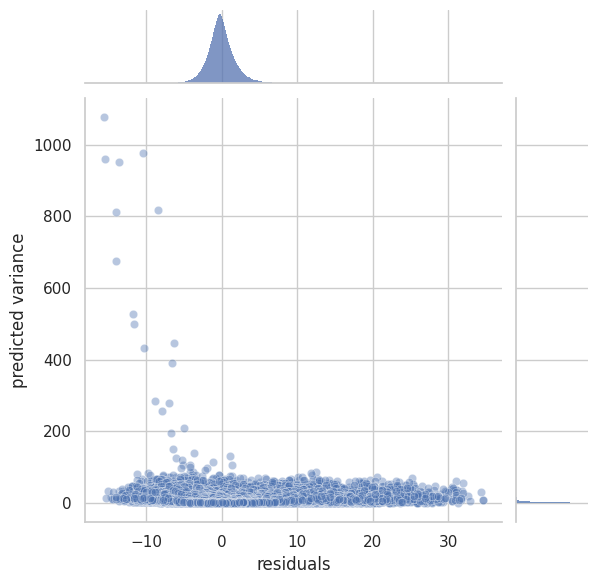

<Figure size 1000x1000 with 0 Axes>

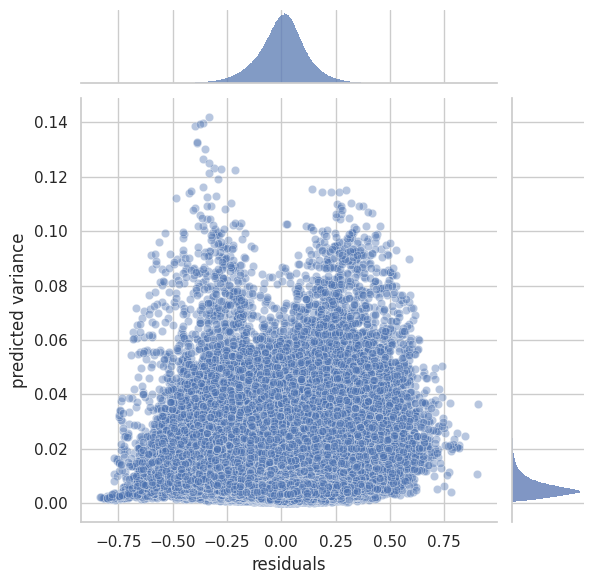

<Figure size 1000x1000 with 0 Axes>

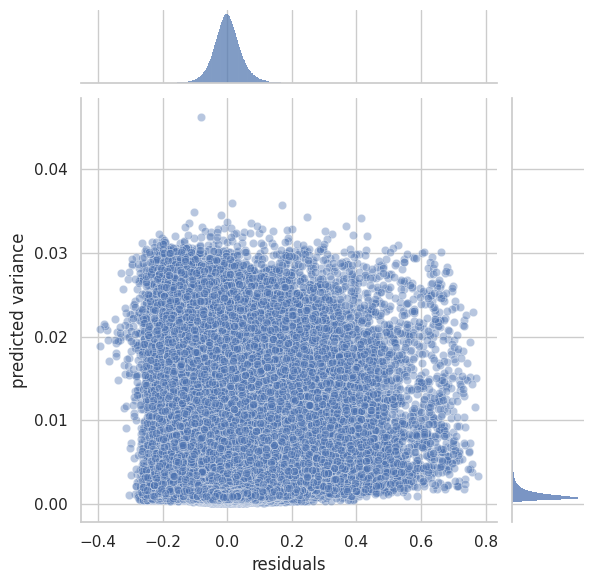

<Figure size 1000x1000 with 0 Axes>

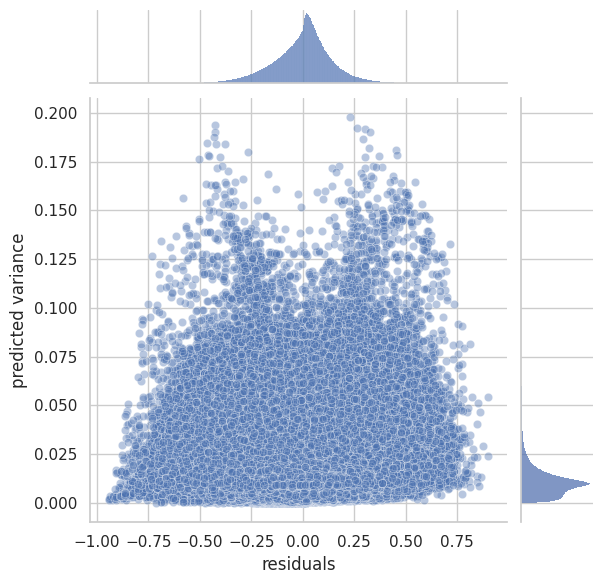

In [33]:
residuals, variances = get_residuals_variances(cfg, N=10, normalize_variance=False)
scatter_residuals_vs_var(residuals, variances, cfg["variable_names"])

### Study spatial correlation in each region

In [172]:
def get_region_arrays(region, cfg):
    gts = []
    longitudes = []
    latitudes = []
    project_ids = []
    for variance_file in tqdm(list(cfg["prediction_dir"].glob("*_variance.tif"))):
        if region != "global": projects = cfg[f"projects_{region}"]
        else: projects = cfg["projects_east"]+cfg["projects_west"]+cfg["projects_north"]
        project = variance_file.stem.split("_")[0]
        if project not in projects: continue
        project_ids.append(project)
        with rasterio.open(variance_file) as fh:
            variance = fh.read(fh.indexes)
            v1 = fh.read(1)
            H, W = v1.shape
            cols, rows = np.meshgrid(np.arange(W), np.arange(H))
            lon, lat = rasterio.transform.xy(fh.transform, rows, cols)
        with rasterio.open(pjoin(cfg['prediction_dir'], f"{project}_mean.tif")) as fh:
            mean = fh.read(fh.indexes)
        with rasterio.open(pjoin(cfg['gt_dir'], f"{project}.tif")) as fh:
            gt = fh.read(fh.indexes)
            gt[2] /= 100 # Cover/Dens normalization!!
            gt[4] /= 100
            valid_mask = fh.read_masks(1)
            gt[:,valid_mask==0] = np.nan
        with rasterio.open(pjoin("assets/data/split_masks", f"{project}.tif")) as fh:
            split_mask = fh.read(fh.indexes)
        any_split = np.logical_or(np.logical_or(split_mask==0., split_mask==1.), split_mask==3.)
        # gt[:,~any_split[0]] = np.nan
        gts.append(gt)
        longitudes.append(np.array(lon))
        latitudes.append(np.array(lat))
    return gts, longitudes, latitudes, project_ids

In [173]:
def plot_xy_trends(gts, project_ids, variable_names):
    for i, variable_name in enumerate(cfg["variable_names"]):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        fig.suptitle(variable_name)
        axs[0].set(xlabel="relative latitude", ylabel="gt")
        axs[1].set(xlabel="relative longitude", ylabel="gt")
        for project, gt in zip(project_ids, gts):
            gtvar = gt[i]
            # latitude (rows) 
            gtlat = np.nanmean(gtvar, axis=1)
            x = np.linspace(0,gt.shape[1]+1,gt.shape[1])
            axs[0].plot(x, gtlat, label=project, alpha=0.9)
            # longitude (cols)
            gtlon = np.nanmean(gtvar, axis=0)
            x = np.linspace(0,gt.shape[2]+1,gt.shape[2])
            axs[1].plot(x, gtlon, label=project, alpha=0.9)
        # axs[0].legend(loc="upper left")
        # axs[1].legend(loc="upper left")
        plt.tight_layout()
        plt.show()

In [174]:
def plot_latlon_trends(gts, latitudes, longitudes):
    # get latitude bounds
    longitude_bounds = np.array([(lon.min(), lon.max()) for i, lon in enumerate(longitudes)])
    latitude_bounds = np.array([(lat.min(), lat.max()) for i, lat in enumerate(latitudes)])
    longitude_min = longitude_bounds[:,0].min()
    longitude_max = longitude_bounds[:,1].max()
    latitude_min = latitude_bounds[:,0].min()
    latitude_max = latitude_bounds[:,1].max()
    # get index offsets
    delta_longitude = longitude_bounds[:,0]-longitude_min
    delta_latitude = latitude_bounds[:,0]-latitude_min
    # create result arrays
    gt_longitude = np.full(
    (len(gts), gts[0].shape[0], int(longitude_max-longitude_min)),
    np.nan
    )
    gt_latitude = np.full(
        (len(gts), gts[0].shape[0], int(latitude_max-latitude_min)),
        np.nan
    )
    # fill arrays
    for i in range(len(gts)):
        # fill longitude
        all_idxs = np.array([
            k for k in range(gt_longitude[i].shape[1])
            if k >= delta_longitude[i] and k < delta_longitude[i]+gts[i].shape[2]
        ])
        i_idxs = (all_idxs-delta_longitude[i]).astype(int)
        gt_longitude[i,:,all_idxs] = np.nanmean(gts[i][:,:,i_idxs], axis=1).transpose()
        # fill latitude
        all_idxs = np.array([
            k for k in range(gt_latitude[i].shape[1])
            if k >= delta_latitude[i] and k < delta_latitude[i]+gts[i].shape[1]
        ])
        i_idxs = (all_idxs-delta_latitude[i]).astype(int)
        gt_latitude[i,:,all_idxs] = np.nanmean(gts[i][:,i_idxs,:], axis=2).transpose()
    # mean
    gt_longitude = np.nanmean(gt_longitude, axis=0)
    gt_latitude = np.nanmean(gt_latitude, axis=0)
    # standardize
    gt_longitude = (gt_longitude-np.nanmean(gt_longitude, axis=1, keepdims=True))/np.nanstd(gt_longitude, axis=1, keepdims=True)
    gt_latitude = (gt_latitude-np.nanmean(gt_latitude, axis=1, keepdims=True))/np.nanstd(gt_latitude, axis=1, keepdims=True)
    # plot
    fig = plt.figure(figsize=(12, 10))
    fig.add_subplot(211)
    plt.plot(
        np.linspace(longitude_min, longitude_max+1, int(longitude_max-longitude_min)), 
        gt_longitude.transpose(), 
        label=cfg["variable_names"]
    )
    plt.xlabel("longitude")
    plt.ylabel("standardized gt values")
    plt.xticks(rotation=45)
    plt.legend()
    fig.add_subplot(212)
    plt.plot(
        np.linspace(latitude_min, latitude_max+1, int(latitude_max-latitude_min)), 
        gt_latitude.transpose(), 
        label=cfg["variable_names"]
    )
    plt.xlabel("latitude")
    plt.ylabel("standardized gt values")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


100%|██████████████████████████████████████| 31/31 [00:10<00:00,  3.47it/s]/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


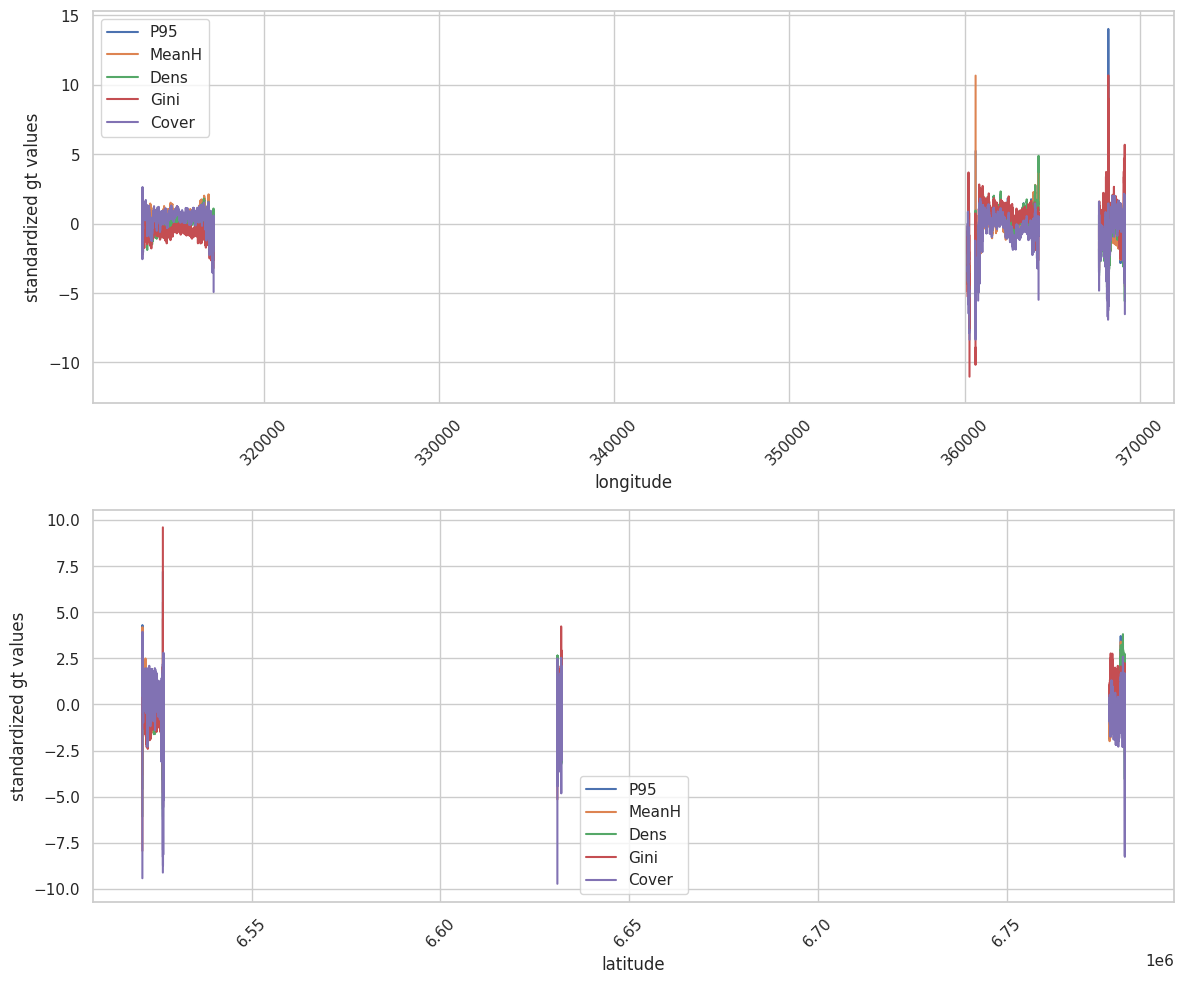

/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


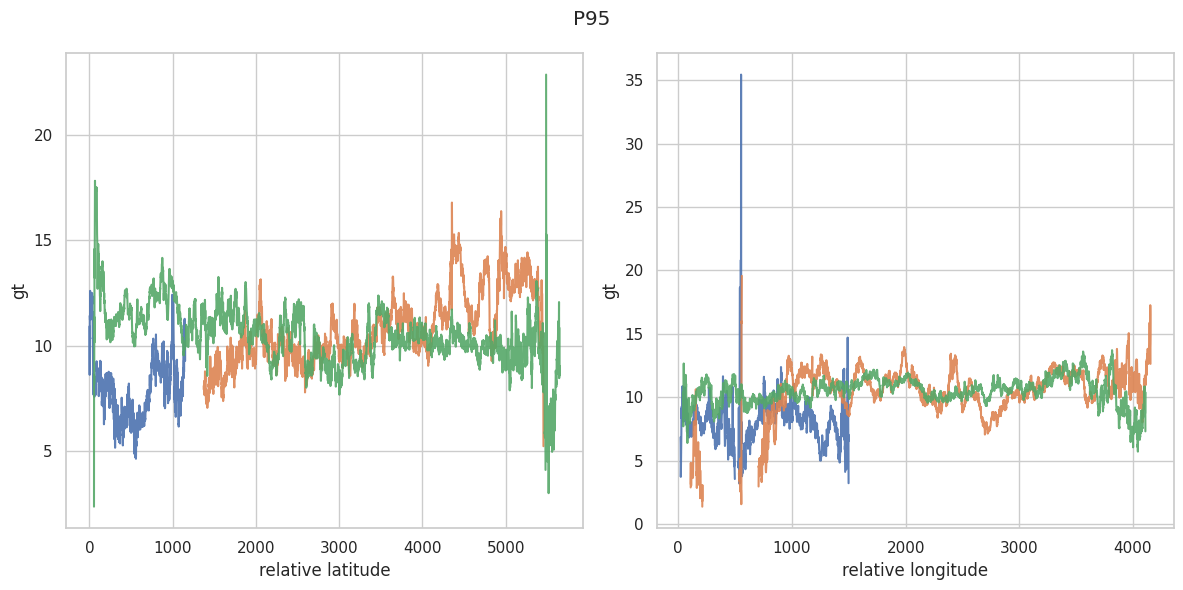

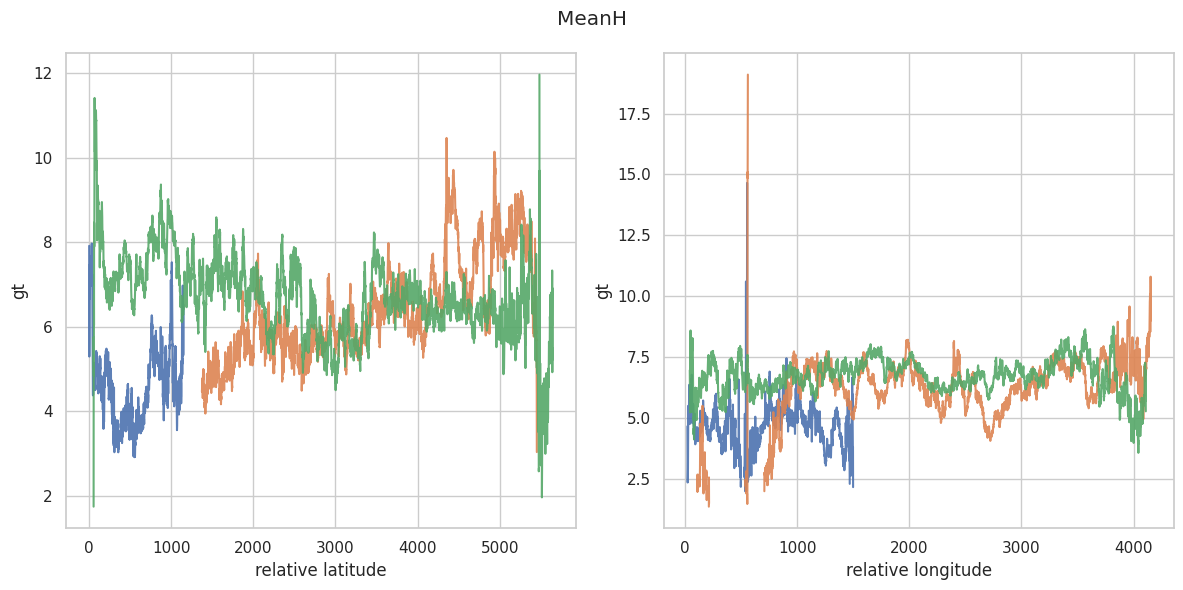

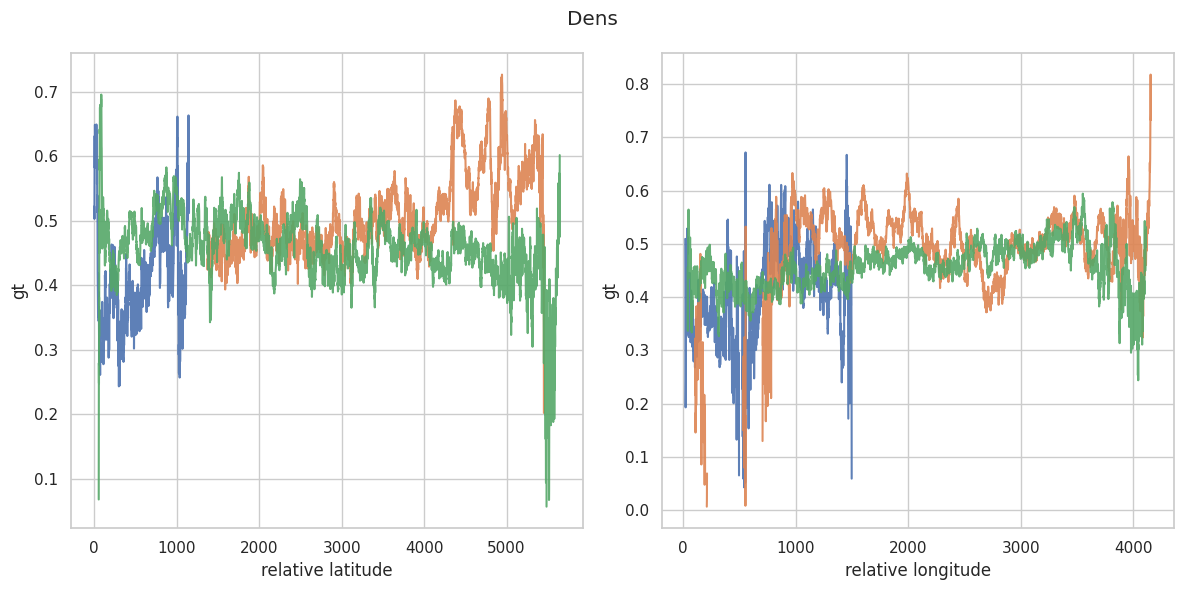

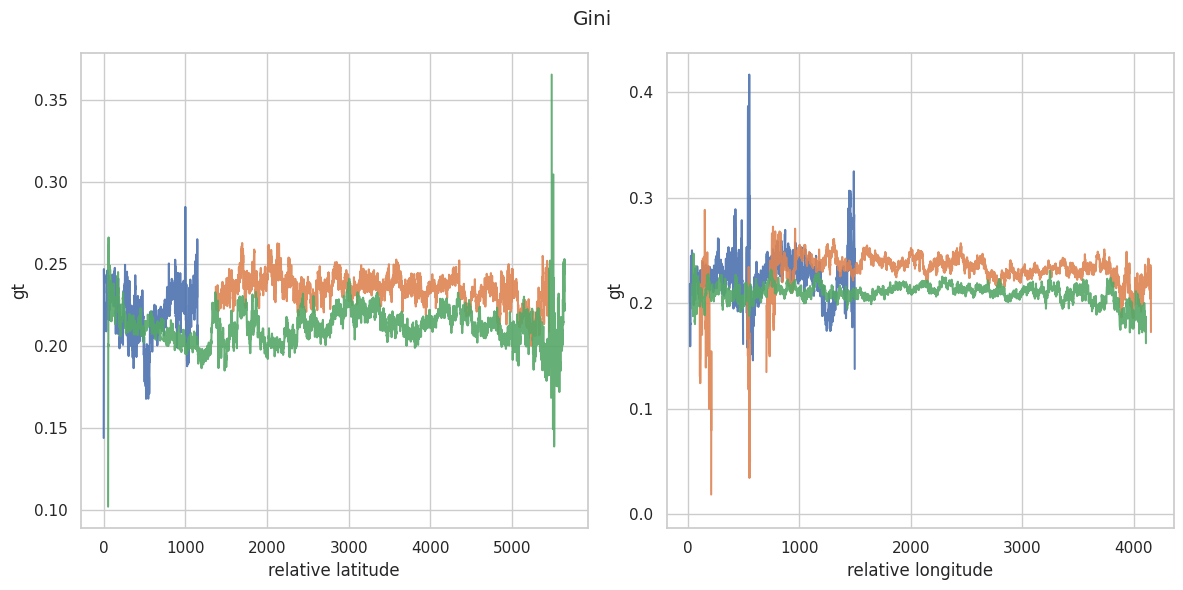

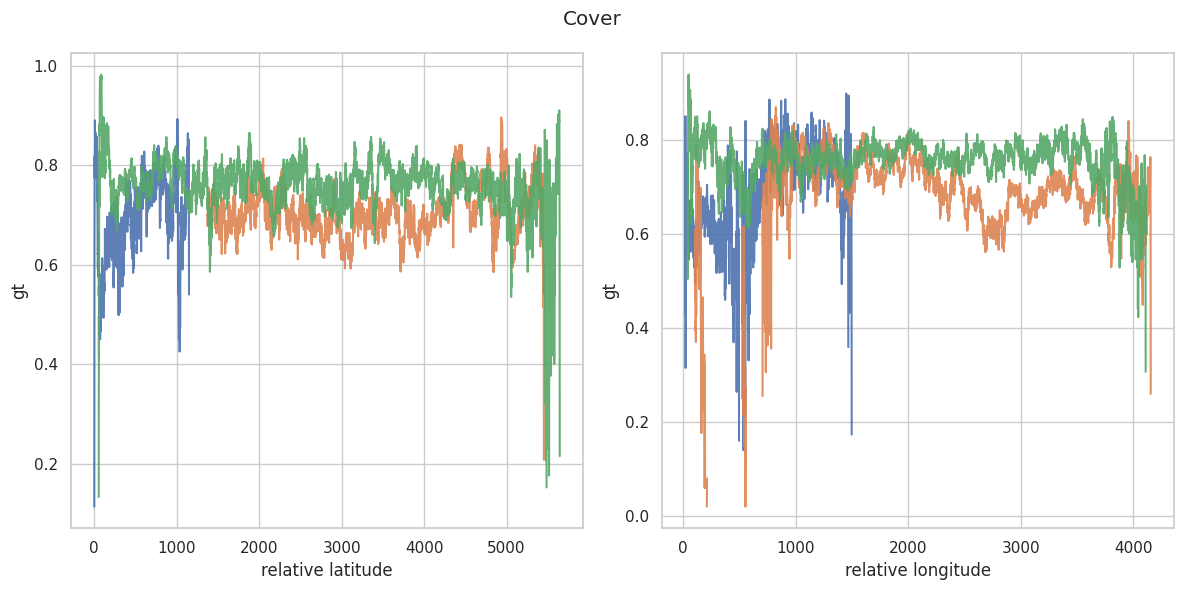

In [175]:
region = "west"
gts, longitudes, latitudes, project_ids = get_region_arrays(region, cfg)
plot_latlon_trends(gts, latitudes, longitudes)
plot_xy_trends(gts, project_ids, cfg["variable_names"])


100%|██████████████████████████████████████| 31/31 [01:20<00:00,  2.58s/it]/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


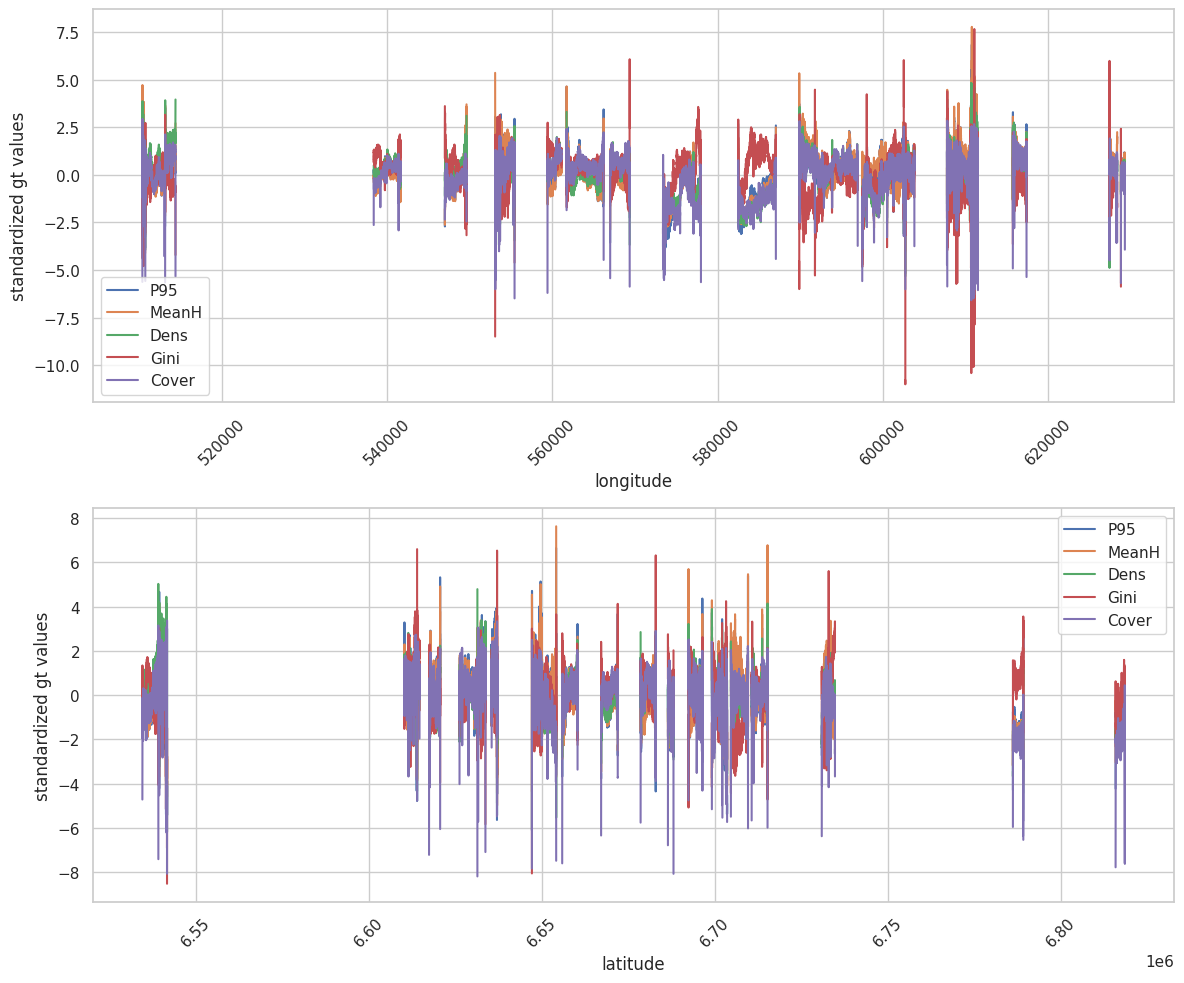

/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


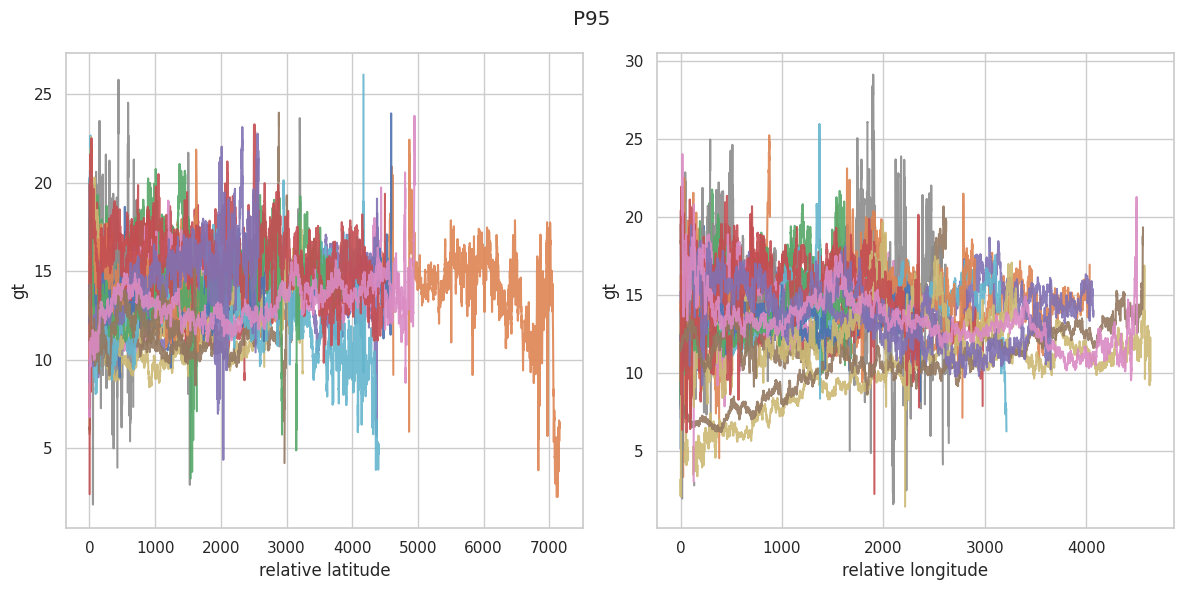

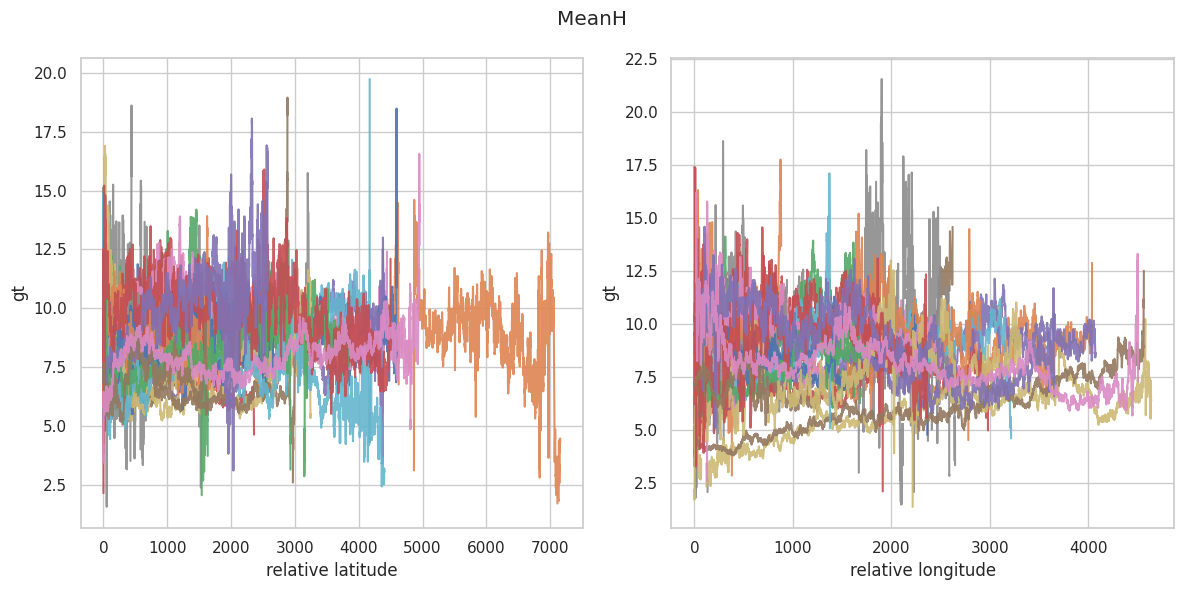

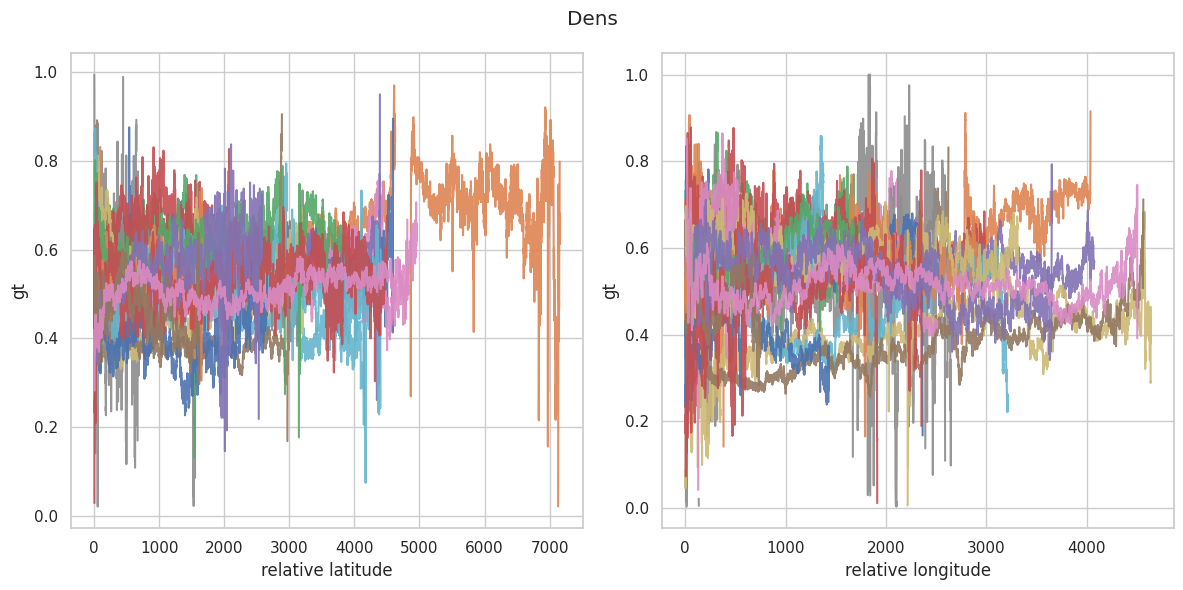

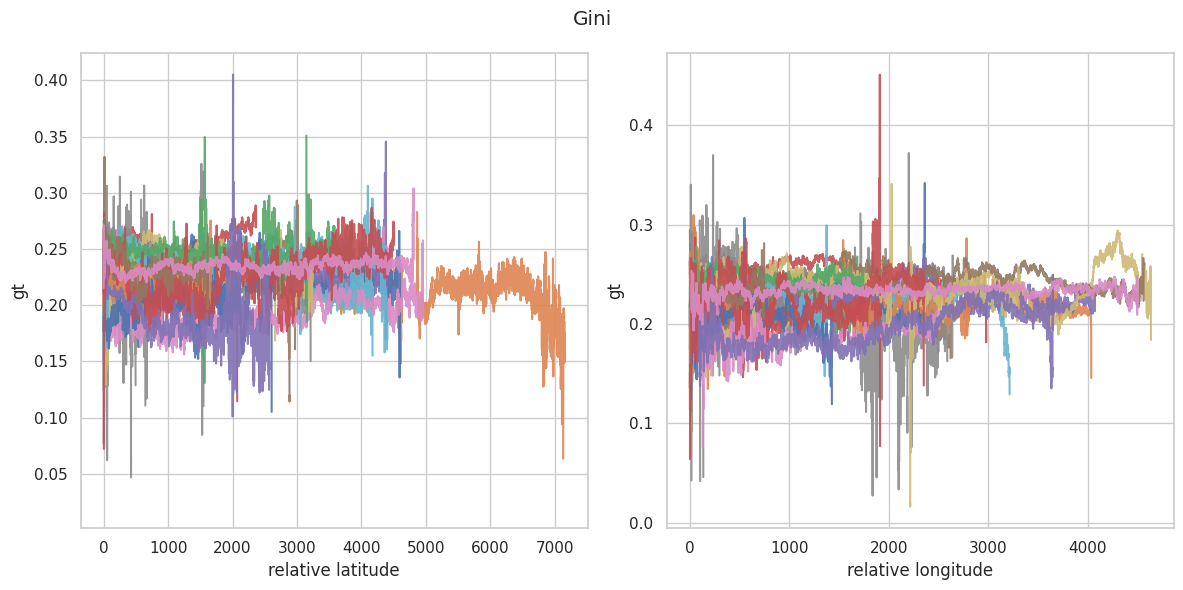

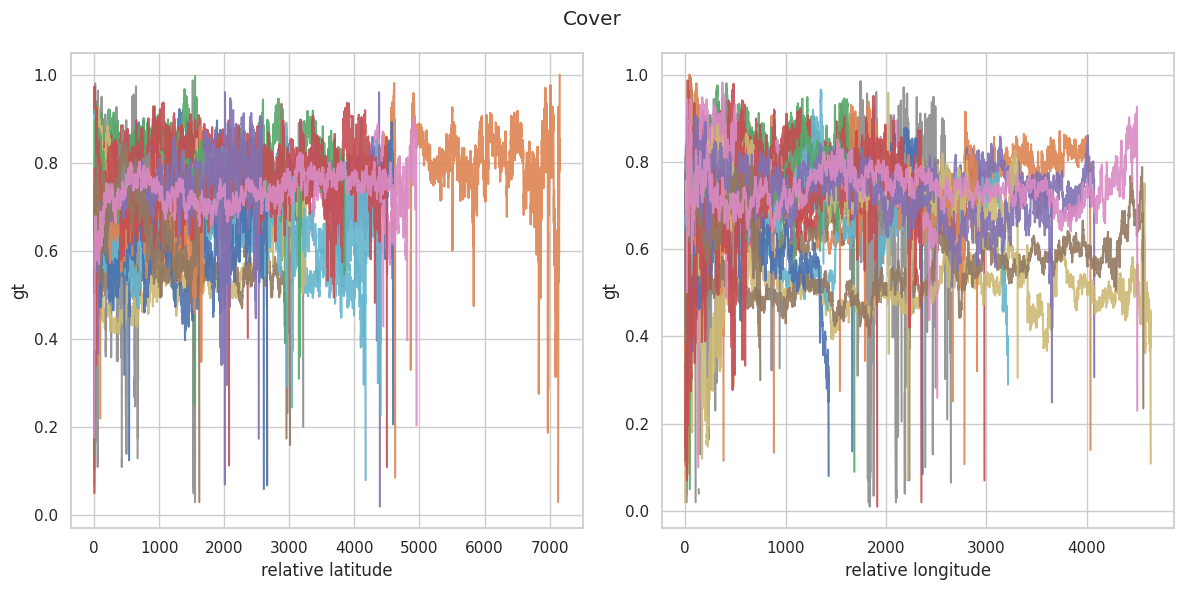

In [176]:
region = "east"
gts, longitudes, latitudes, project_ids = get_region_arrays(region, cfg)
plot_latlon_trends(gts, latitudes, longitudes)
plot_xy_trends(gts, project_ids, cfg["variable_names"])

/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


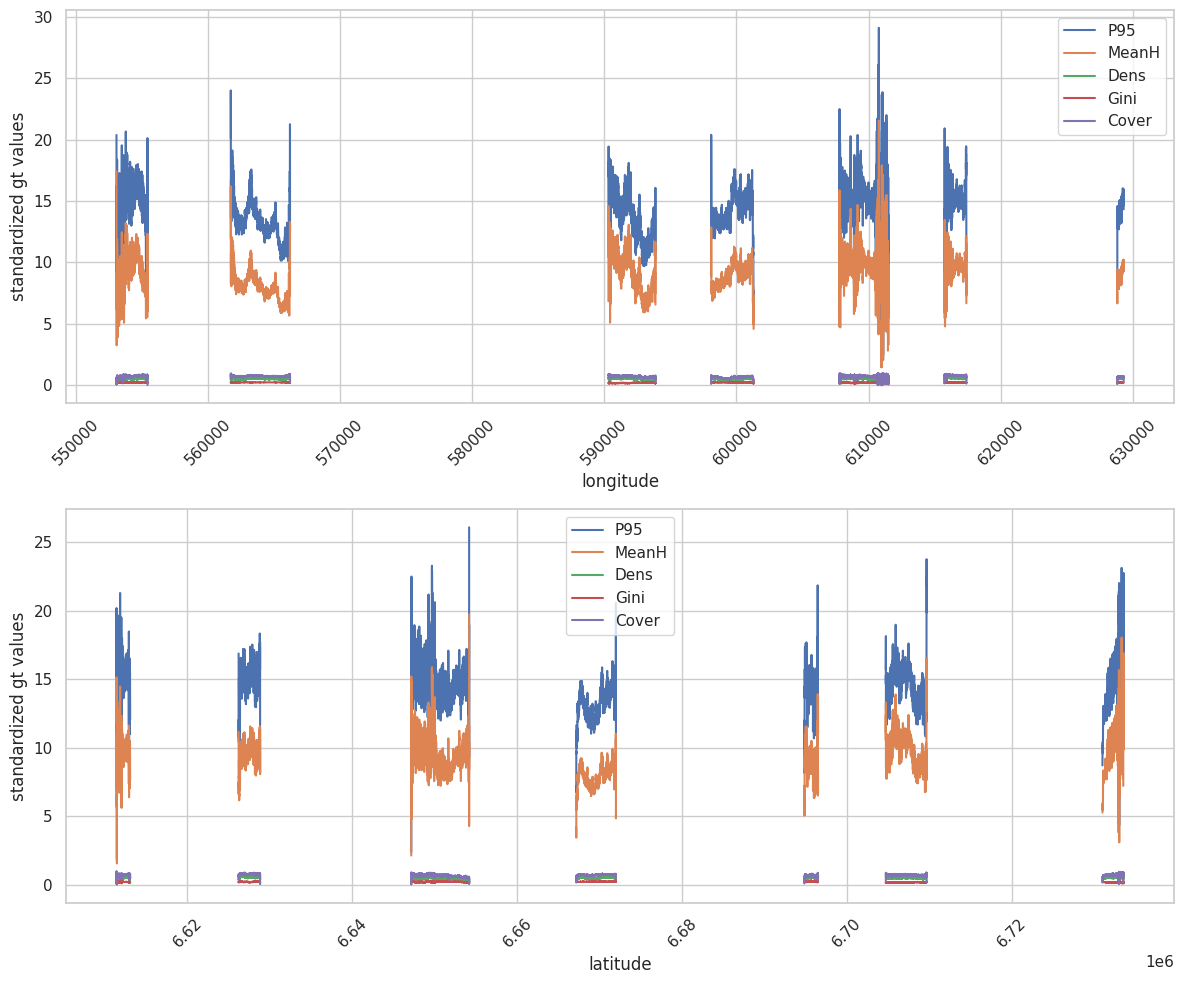

In [167]:
plot_latlon_trends(gts, latitudes, longitudes)

In [60]:
    np.nanmin(gt,axis=(1,2))

array([ 1.3000000e+00,  1.3000000e+00,  2.9231219e-02, -4.4408921e-16,
        1.0000000e+00], dtype=float32)

In [40]:
any_split.shape, gt.shape

((1, 5644, 4115), (5, 5644, 4115))

In [41]:
any_split[0].shape, gt[0].shape

((5644, 4115), (5644, 4115))

In [52]:
gt[:,any_split[0]] = np.nan
gt.shape

(5, 5644, 4115)

In [56]:
np.nanmean(gt, axis=1)

array([[-999999.5, -999999.5, -999999.5, ..., -999999.5, -999999.5,
        -999999.5],
       [-999999.5, -999999.5, -999999.5, ..., -999999.5, -999999.5,
        -999999.5],
       [-999999.5, -999999.5, -999999.5, ..., -999999.5, -999999.5,
        -999999.5],
       [-999999.5, -999999.5, -999999.5, ..., -999999.5, -999999.5,
        -999999.5],
       [-999999.5, -999999.5, -999999.5, ..., -999999.5, -999999.5,
              0. ]], dtype=float32)

In [54]:
np.isnan(gt).sum()

93904300

In [63]:
gts[0].shape, longitudes[0].shape, latitudes[0].shape

((5, 1199, 2944), (1199, 2944), (1199, 2944))

In [122]:
longitude_bounds = np.array([(lon.min(), lon.max()) for i, lon in enumerate(longitudes)])
latitude_bounds = np.array([(lat.min(), lat.max()) for i, lat in enumerate(latitudes)])

In [123]:
longitude_bounds, latitude_bounds

(array([[615730.60514433, 632450.60514433],
        [608870.60514433, 635310.60514433],
        [598080.60514433, 630210.60514433],
        [607760.60514433, 636800.60514433],
        [607720.60514433, 632800.60514433],
        [628810.60514433, 633600.60514433],
        [553090.60514433, 576590.60514433],
        [590220.60514433, 626720.60514433],
        [561720.60514433, 606730.60514433]]),
 array([[6626212.03320544, 6652262.03320544],
        [6611402.03320544, 6626912.03320544],
        [6649992.03320544, 6691692.03320544],
        [6611402.03320544, 6627972.03320544],
        [6704682.03320544, 6754202.03320544],
        [6694802.03320544, 6711432.03320544],
        [6647142.03320544, 6692112.03320544],
        [6730952.03320544, 6757802.03320544],
        [6667152.03320544, 6715262.03320544]]))

In [124]:
longitude_min = longitude_bounds[:,0].min()
longitude_max = longitude_bounds[:,1].max()
latitude_min = latitude_bounds[:,0].min()
latitude_max = latitude_bounds[:,1].max()

In [125]:
longitude_min, longitude_max

(553090.6051443298, 636800.6051443298)

In [149]:
gt_longitude = np.full(
    (len(gts), gts[0].shape[0], int(longitude_max-longitude_min)),
    np.nan
)
gt_latitude = np.full(
    (len(gts), gts[0].shape[0], int(latitude_max-latitude_min)),
    np.nan
)
delta_longitude = longitude_bounds[:,0]-longitude_min
delta_latitude = latitude_bounds[:,0]-latitude_min

In [150]:
# fill arrays
for i in range(len(gts)):
    # fill longitude
    all_idxs = np.array([
        k for k in range(gt_longitude[i].shape[1])
        if k >= delta_longitude[i] and k < delta_longitude[i]+gts[i].shape[2]
    ])
    i_idxs = (all_idxs-delta_longitude[i]).astype(int)
    gt_longitude[i,:,all_idxs] = np.nanmean(gts[i][:,:,i_idxs], axis=1).transpose()
    # fill latitude
    all_idxs = np.array([
        k for k in range(gt_latitude[i].shape[1])
        if k >= delta_latitude[i] and k < delta_latitude[i]+gts[i].shape[1]
    ])
    i_idxs = (all_idxs-delta_latitude[i]).astype(int)
    gt_latitude[i,:,all_idxs] = np.nanmean(gts[i][:,i_idxs,:], axis=2).transpose()
# mean
gt_longitude = np.nanmean(gt_longitude, axis=0)
gt_latitude = np.nanmean(gt_latitude, axis=0)
# standardize
gt_longitude = (gt_longitude-np.nanmean(gt_longitude, axis=1, keepdims=True))/np.nanstd(gt_longitude, axis=1, keepdims=True)
gt_latitude = (gt_latitude-np.nanmean(gt_latitude, axis=1, keepdims=True))/np.nanstd(gt_latitude, axis=1, keepdims=True)

/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == "__main__":
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/scratch/ewalt/miniconda3/envs/bfs-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


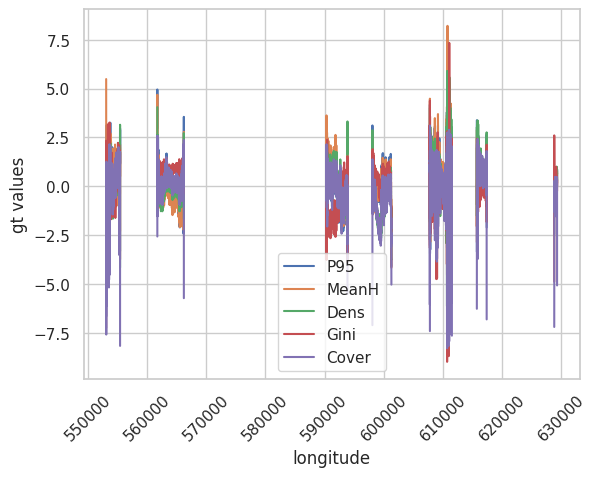

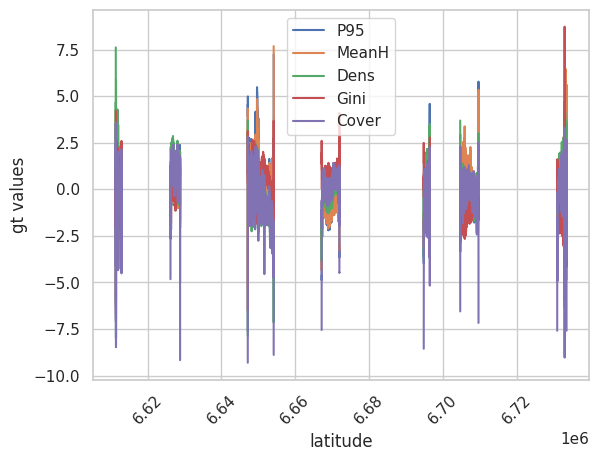

In [154]:
plt.plot(
    np.linspace(longitude_min, longitude_max+1, int(longitude_max-longitude_min)), 
    gt_longitude.transpose(), 
    label=cfg["variable_names"]
)
plt.xlabel("longitude")
plt.ylabel("gt values")
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.plot(
    np.linspace(latitude_min, latitude_max+1, int(latitude_max-latitude_min)), 
    gt_latitude.transpose(), 
    label=cfg["variable_names"]
)
plt.xlabel("latitude")
plt.ylabel("gt values")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [49]:
longitude_bounds[:,0]-longitude_min

array([54610., 47030.,     0.])

In [31]:
gt_longitude.shape, gt_latitude.shape

((5, 88560), (5, 309770))

In [35]:
for j, lon in enumerate(np.linspace(longitude_min, longitude_max+1, gt_longitude.shape[1])):
    # find which arrays have that lon
    gt_values = []
    for array in longitude_bounds:
        if lon>=array[1] and lon<=array[2]:
            gt_values.append(gt[array[0]])

0 313030.60514432983


In [33]:
rasterio.transform.xy?

In [60]:
gts[0].shape, gts[0][:,:,[0,1]].shape, gts[0][:,[0,1],:].shape

((5, 1199, 2944), (5, 1199, 2), (5, 2, 2944))

In [61]:
np.nanmean(gts[0][:,:,[0,1]], axis=1).shape

(5, 2)